## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 70 kB 8.6 MB/s 
     |████████████████████████████████| 112 kB 61.7 MB/s 
     |████████████████████████████████| 1.1 MB 48.6 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
     |████████████████████████████████| 288 kB 52.2 MB/s 
     |████████████████████████████████| 144 kB 67.6 MB/s 
     |████████████████████████████████| 271 kB 55.1 MB/s 
     |████████████████████████████████| 94 kB 976 kB/s 
     |████████████████████████████████| 749 kB 51.6 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data_test.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

TypeError: ignored

In [6]:
crypto.binance_client

### Generate Candles and build features from technical analysis

In [7]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [8]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

In [9]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

190

,Close,Pred Close
Date,,
2022-05-07 06:46:00,35806.27,36075.752670
2022-05-07 07:01:00,35810.01,36070.796994
2022-05-07 07:16:00,35835.31,36065.081928
2022-05-07 07:31:00,35934.62,36029.547702
2022-05-07 07:46:00,35921.60,36025.783483
...,...,...
2022-06-27 19:16:00,20855.65,20895.142539
2022-06-27 19:31:00,20868.56,20909.881910
2022-06-27 19:46:00,20855.37,20922.061613


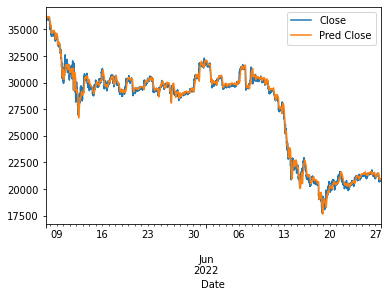

In [10]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

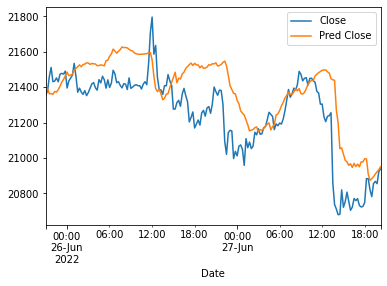

In [11]:
df_preds_true.dropna().iloc[-new_time_steps:].plot()

Fee: 0.025
----------------------
Buy      151 ( 67 ok 84 ko )
Avg PCT gain: 1.0021178362412875
Avg PCT loss: 0.9981723997172419
Wins  PCT   0.44370860927152317
Avg PCT Gain.    1.0021178362412875
No-op    0
Wallet   -416.52524999999935
Drawback -391.54999999999995
Kelly Fraction    -0.11039260751570884
Total earned -416.52524999999935


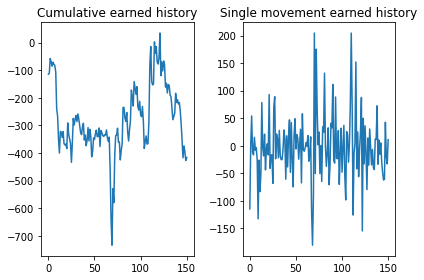

In [20]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-200:], ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

All caught up..!
size of dataset: (169808, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952


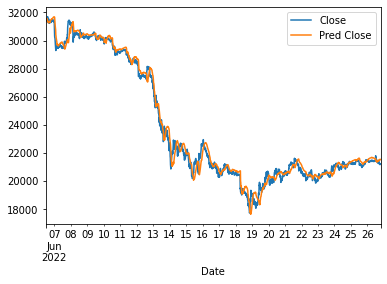

In [ ]:
investment = 100.
conservative_kelly = kelly_frac*.5
portfolio = investment
order_status = "not_filled"

while True:

  ldata_df_new = crypto.load_cryptos(tickers,save = False)
  can_btc = fb.Candles(ldata_df_new,"Bitcoin")
  can_btc.buildfeatures()
  ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = "15m",
                  lownorm = 0.2, upnorm= 0.8)

  ts_btc.candles2ts()
  ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
  ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
  initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
  loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
  loaded_model.sats2model()
  loaded_model.load_model(model_name)
  loaded_model.sats2pred(predict_on_test = False)
  loaded_model.load_scaler(model_name + '/scaler.sav')
  preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
  new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
  df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
  df_preds_true.dropna().iloc[-new_time_steps:].plot()
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)

  prev_true_close = df_preds_true_shifted.iloc[-2,0]
  prev_pred_close = df_preds_true_shifted.iloc[-2,1]
  pred_close = df_preds_true_shifted.iloc[-1,1]

  fee = 0.025

  elapsed_minutes = (pd.Timestamp(datetime.now()) - df_preds_true.index[-1]).seconds/crypto.dt
  time_condition = delta.seconds/crypto.dt -1. < elapsed_minutes <  delta.seconds/crypto.dt + 1.

  if time_condition and order_status == "not_filled" :

    if prev_true_close*(1+fee) < pred_close:

        #get price
        price = crypto._binanc_client.get_symbol_ticker(symbol=tickers[0])
        # Calculate how much to buy
        buy_quantity = round(portfolio*conservative_kelly / float(price['price']))
        buy_quantity = 0.0001
        order = crypto._binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)
        
        order_status= "filled"
        






In [ ]:
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)
  df_preds_true_shifted

,Close,Pred Close
Date,,
2017-08-17 06:31:00,NaN,NaN
2017-08-17 06:46:00,NaN,NaN
2017-08-17 07:01:00,NaN,NaN
2017-08-17 07:16:00,NaN,NaN
2017-08-17 07:31:00,NaN,NaN
...,...,...
2022-06-26 18:16:00,21423.38,21523.698347
2022-06-26 18:31:00,21496.15,21526.703175
2022-06-26 18:46:00,21476.19,21513.184720


In [ ]:
df_preds_true

,Close,Pred Close
Date,,
2017-08-17 06:31:00,4345.45,NaN
2017-08-17 06:46:00,4324.35,NaN
2017-08-17 07:01:00,4316.62,NaN
2017-08-17 07:16:00,4291.38,NaN
2017-08-17 07:31:00,4300.00,NaN
...,...,...
2022-06-26 18:16:00,21192.14,21523.698347
2022-06-26 18:31:00,21215.06,21526.703175
2022-06-26 18:46:00,21186.64,21513.184720
